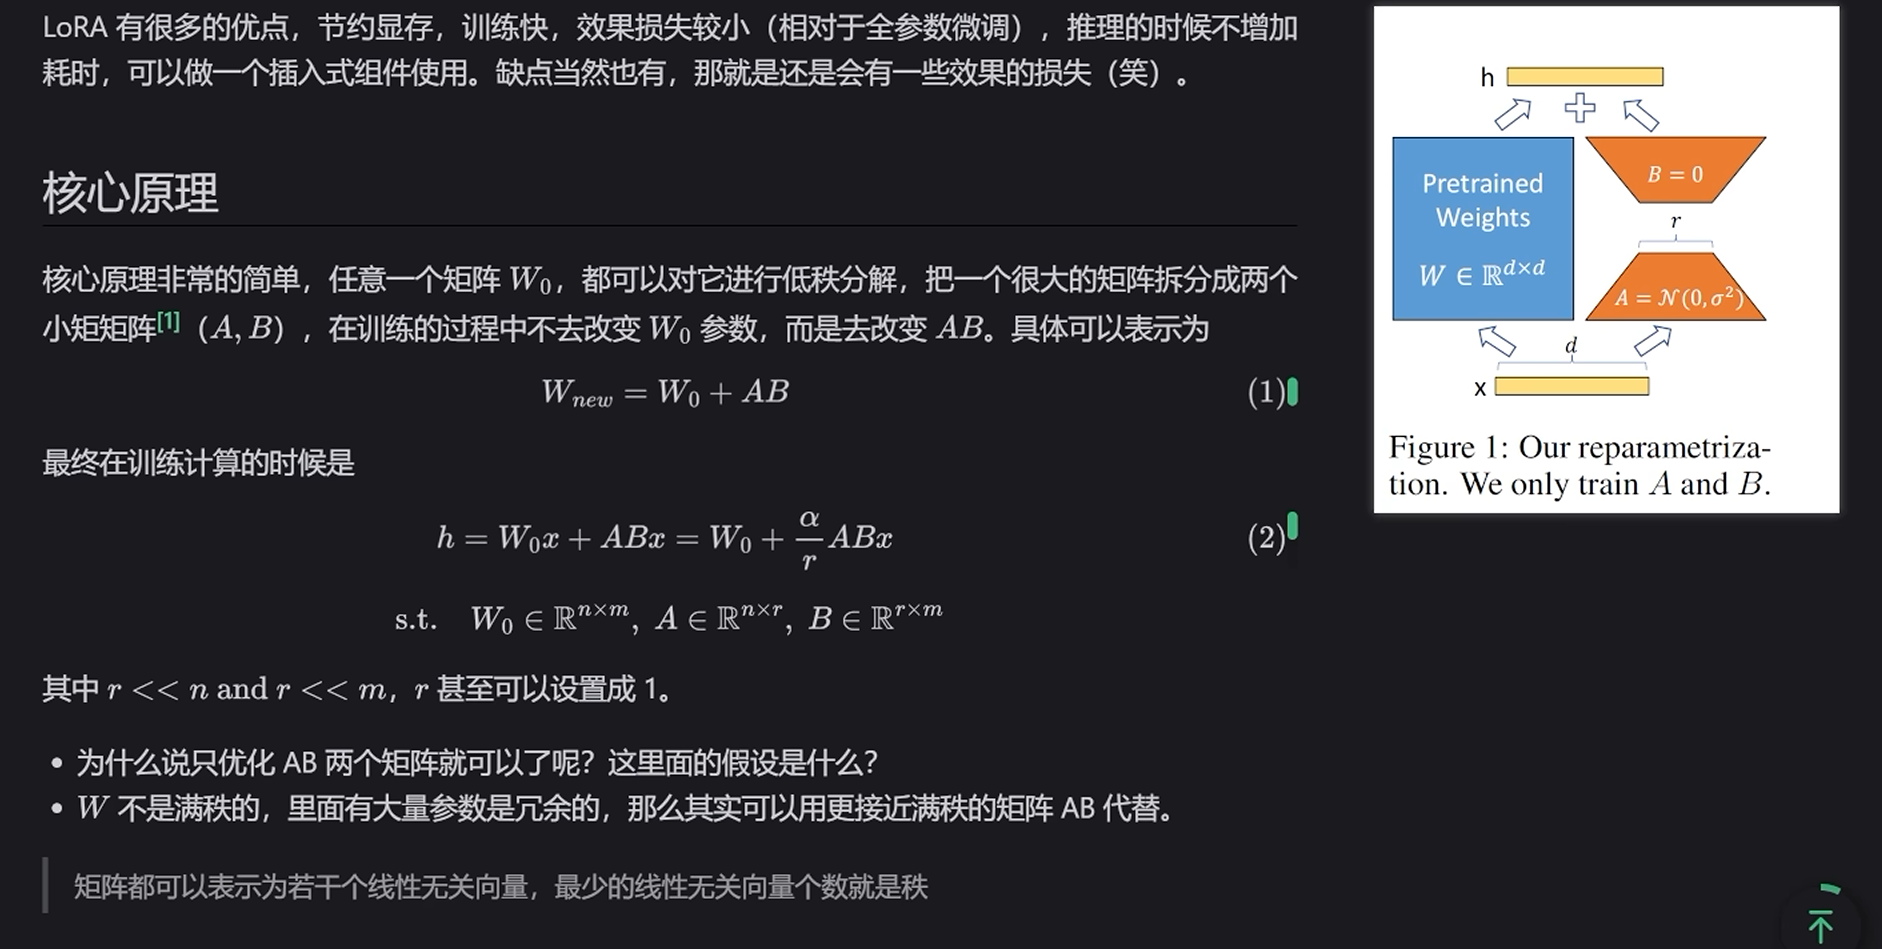

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [5]:
class LinearLoRALayer(nn.Module):
    def __init__(self, in_features, out_features, merge=False, rank=8, lora_alpha=16,dropout=0.1):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.merge = merge
        self.rank = rank
        self.lora_alpha = lora_alpha
        self.linear = nn.Linear(in_features, out_features)
        self.dropout = nn.Dropout(dropout) if dropout>0 else nn.Identity()
        # nn.Identity实际上是一个恒等映射，不对输入进行任何变换或操作，只是简单地将输入返回作为输出。
        if rank >0:
            self.lora_a = nn.Parameter(torch.zeros(out_features, rank))
            nn.init.kaiming_normal_(self.lora_a, a=0.01)
            # 在调用凯明初始化的时候注释里写的高斯分布，a表示的是leaky relu的负斜率系数，一般是0.01这样的小值，不可能超过1
            self.lora_b = nn.Parameter(torch.zeros(rank, in_features)) # 零矩阵
            self.scale = lora_alpha/rank
            # 只对AB训练 不对线性层训练
            self.linear.weight.requires_grad = False
            self.linear.bias.requires_grad = False
        if merge:
            self.merge_weight()

    def forward(self, X):
        if self.rank>0 and not self.merge:
        # 注意实际上是X@ W^T    所以W是out_feature in_feture形状的
            output = self.linear(X)+self.scale*(X@(self.lora_a @ self.lora_b).T)
        elif self.rank >0 and self.merge:
            output = self.linear(X)
        else:
            output = self.linear(X)
        return self.dropout(output)


    def merge_weight(self):
        if self.merge and self.rank>0:
            self.linear.weight.data +=self.scale*(self.lora_a @ self.lora_b) # 形状一样不用转置
            
    def unmerge_weight(self, ):
        if self.rank > 0:
            self.linear.weight.data -= self.scale * (self.lora_a @ self.lora_b)

In [6]:
# 写一段测试代码
# Test the LoRALinear layer
batch_size = 32
seq_len = 128
in_features = 768
out_features = 512
rank = 8
lora_alpha = 16
dropout = 0.1

# Create a test input
x = torch.randn(batch_size, seq_len, in_features)

# Test regular mode (no merge)
lora_layer = LinearLoRALayer(
    in_features=in_features,
    out_features=out_features,
    rank=rank,
    lora_alpha=lora_alpha,
    dropout=dropout,
    merge=False
)

# Forward pass
output = lora_layer(x)
print(f"Output shape (no merge): {output.shape}")  # Should be [batch_size, seq_len, out_features]

# Test merged mode
lora_layer_merged = LinearLoRALayer(
    in_features=in_features,
    out_features=out_features,
    rank=rank,
    lora_alpha=lora_alpha,
    dropout=dropout,
    merge=True
)

# Forward pass with merged weights
output_merged = lora_layer_merged(x)
print(f"Output shape (merged): {output_merged.shape}")  # Should be [batch_size, seq_len, out_features]

# Test weight merging/unmerging
lora_layer.merge_weight()
output_after_merge = lora_layer(x)
lora_layer.unmerge_weight()
output_after_unmerge = lora_layer(x)

print("Max difference after merge/unmerge cycle:", 
      torch.max(torch.abs(output - output_after_unmerge)).item())

Output shape (no merge): torch.Size([32, 128, 512])
Output shape (merged): torch.Size([32, 128, 512])
Max difference after merge/unmerge cycle: 3.2575807571411133


In [9]:
output_after_merge.shape

torch.Size([32, 128, 512])

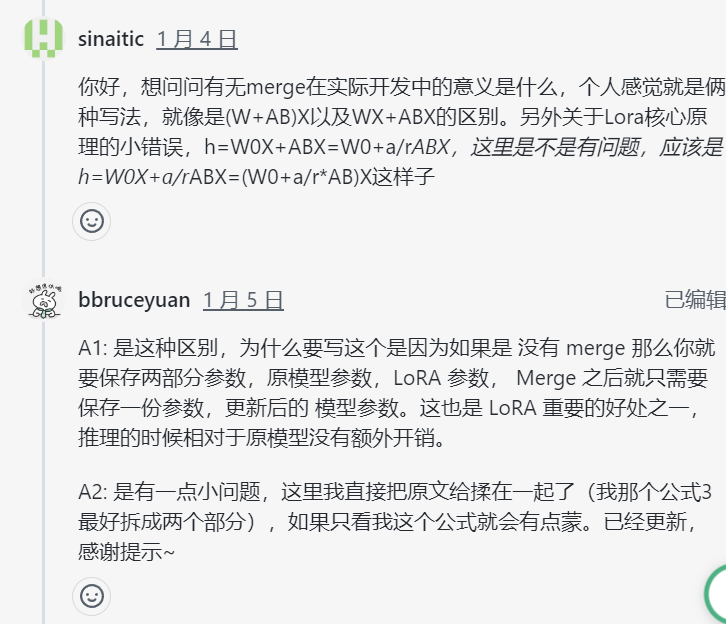